In [ ]:
!pip install optuna

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
cities_by_region = {
    "Астана": ["Астана"],
    "Алматы": ["Алматы"],
    "Шымкент": ["Шымкент"],
    "Абайская область": ["Семей", "Аягоз", "Улкен Нарын", "Кокпекты", "Аксуат"],
    "Акмолинская область": [
        "Акколь (Аккольский р-н)", "Атбасар", "Балкашино", "Есиль",
        "Кокшетау", "Макинск", "Степногорск", "Щучинск", "Астраханка"
    ],
    "Актюбинская область": ["Актобе", "Кандыагаш", "Шалкар", "Аккыстау"],
    "Алматинская область": [
        "Конаев (Капшагай)", "Талдыкорган", "Талгар", "Хоргос", "Коктобе", "Сарыозек", "Ушарал"
    ],
    "Атырауская область": ["Атырау", "Кульсары"],
    "Западно-Казахстанская область": [
        "Аксай", "Казталовка", "Жангала", "Уральск", "Жымпиты", "Каратобе", "Таскала"
    ],
    "Жамбылская область": ["Тараз", "Кордай", "Бауыржана Момышулы"],
    "Карагандинская область": [
        "Караганда", "Жезказган", "Сарань", "Сатпаев", "Темиртау", "Шахтинск", 
        "Балхаш", "Жанаарка", "Баянаул"
    ],
    "Костанайская область": [
        "Аркалык", "Костанай", "Лисаковск", "Рудный", 
        "Жаксы", "Затобольск", "Карабалык (Карабалыкский р-н)", "Боровской", 
        "Денисовка", "Аулиеколь"
    ],
    "Кызылординская область": ["Аральск", "Жалагаш", "Жанакорган", "Кызылорда", "Шиели", "Шаульдер"],
    "Мангистауская область": ["Актау", "Жанаозен", "Форт-Шевченко", "Мангистау", "Бейнеу"],
    "Павлодарская область": ["Аксу", "Павлодар", "Экибастуз", "Кашыр", "Железинка"],
    "Северо-Казахстанская область": ["Петропавловск", "Новоишимский", "Большая Владимировка", "Акжар"],
    "Туркестанская область": [
        "Арысь", "Жетысай", "Казыгурт", "Ленгер",
        "Сарыагаш", "Туркестан", "Атакент", "Кентау", "Сай-Отес", "Шаульдер"
    ],
    "Улытауская область": ["Жезказган"],
    "Восточно-Казахстанская область": [
        "Алтай", "Глубокое", "Зайсан", "Риддер", "Усть-Каменогорск", "Шемонаиха", 
        "Урджар", "Калбатау"
    ],
    "Байконыр": ["Байконыр"]
}


In [3]:
# Загружаем данные
df = pd.read_csv('df_result.csv', sep=',')


def add_region(city):
    for region, cities in cities_by_region.items():
        if city in cities:
            return region
    
    return 'Неизвестно'


#  Добавляем область
df['Область'] = df['Город'].apply(add_region)
y = df['Цена']
X = df.drop('Цена', axis=1)

# Кодируем
encoder = OneHotEncoder(sparse_output=False)
cat_col_name = X.select_dtypes(include='object').columns
encoded = encoder.fit_transform(X[cat_col_name])
cat_cot_encoded = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cat_col_name))
X = X.drop(cat_col_name, axis=1)
X_encod = pd.concat([X, cat_cot_encoded], axis=1)

In [6]:
df['Область'].value_counts()

Область
Шымкент                           186
Западно-Казахстанская область     177
Карагандинская область            172
Астана                            171
Актюбинская область               144
Восточно-Казахстанская область    140
Алматы                            137
Абайская область                  129
Павлодарская область              108
Костанайская область               97
Атырауская область                 95
Мангистауская область              82
Акмолинская область                62
Кызылординская область             58
Жамбылская область                 33
Туркестанская область              27
Северо-Казахстанская область       26
Алматинская область                14
Байконыр                            1
Name: count, dtype: int64

In [7]:
# Разбиваем данные
X_train, X_test, y_train, y_test = train_test_split(X_encod, y, test_size=0.2, random_state=42)

In [8]:
from tqdm.notebook import tqdm

In [9]:
best_params = {}


def tune_model(x_train, y_train, x_test, y_test, param_stages: list, n_trials: int, out_print: bool, stages: list):


    def print_mode(*args, **kwargs):
        if out_print:
            print(*args, **kwargs)


    global best_params
    best_scores = []

    #  Перебираем этапы параметров
    for stage in stages:
        param_stage = param_stages[stage - 1]
        params = best_params.copy()

        print_mode(f' --- Подбор параметров, этап: {stage} --- ', flush=True)
        # Создаем исследование для одного этапа (дальше запустим его в цикл)
        study = optuna.create_study(direction='minimize')


        # Функция которая будет вызываться на каждой итерации (выбирает парамеры, обучает модель, возвращает ошибку)
        def objective(trial):
            params.update(param_stage(trial))
            model = XGBRegressor(**params, random_state=42)
            score = round(cross_val_score(
                model, 
                x_train, 
                y_train, 
                cv=5, 
                scoring='neg_root_mean_squared_error', 
                n_jobs=-1
                ).mean())

            return -score

        #  Запускаем подбор гиперпараметров
        iter = 0
        pbar = tqdm(range(n_trials), unit='trial', leave=False)

        for _ in pbar: #  n_trials итераций поиска (испытаний) с прогресс баром
            study.optimize(objective, n_trials=1)
            iter += 1
            pbar.set_description(f'Trial: {iter}')
        
        #  Проверяем улучшение ошибки
        best_score = study.best_trial.value if study.best_trial else None
        
        if best_score is None:
            print_mode(f'На этапе {stage} не удалось найти лучшую метрику.', flush=True)
            continue

        best_params.update(study.best_params)

        if not best_scores or best_score < best_scores[-1]: #  Добавляем первую ошибку
            best_scores.append(best_score)
            print_mode(f'Метрика улучшилась после {stage} этапа.', flush=True)
            print_mode(f'Лучшая метрика: {best_score}', flush=True)
        else:
            print_mode(f'Метрика ухудшилась после {stage} этапа.', flush=True)
            print_mode(f'Лучшая метрика: {best_score}', flush=True)


    best_model = XGBRegressor(**best_params, random_state=42)
    best_model.fit(x_train, y_train)
    y_pred = best_model.predict(x_test)
    y_pred_train = best_model.predict(x_train)

    rmse_test = np.abs(root_mean_squared_error(y_test, y_pred))
    rmse_train = np.abs(root_mean_squared_error(y_train, y_pred_train))
    print_mode(f'Best parametrs: {best_params}', flush=True)
    print_mode(f'RMSE test: {rmse_test}', flush=True)
    print_mode(f'RMSE train: {rmse_train}', flush=True)

    return best_model, rmse_test, rmse_train, best_params

In [10]:
#  Диапазон гиперпараметров для подбора
def params_stage_1(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 10, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 10),
        'objective': 'reg:squarederror'
    }


def params_stage_2(trial):
    return {
        'subsample': trial.suggest_float('subsample', 0.5, 1), 
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1), 
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1), 
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.5, 1), 
    }


def params_stage_3(trial):
    return {
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10, log=True),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'gamma': trial.suggest_float('gamma', 1e-8, 10, log=True),
    }


param_stages = [params_stage_1, params_stage_2, params_stage_3]

In [11]:
#  Запускаем подбор гиперпараметров
best_params = {}

model, rmse_ts, rmse_tr, _ = tune_model(
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    param_stages, 
    n_trials=40, 
    out_print=True, 
    stages=[1, 2, 3]
    )

 --- Подбор параметров, этап: 1 --- 


  0%|          | 0/40 [00:00<?, ?trial/s]

Метрика улучшилась после 1 этапа.
Лучшая метрика: 431341.0
 --- Подбор параметров, этап: 2 --- 


  0%|          | 0/40 [00:00<?, ?trial/s]

Метрика улучшилась после 2 этапа.
Лучшая метрика: 425853.0
 --- Подбор параметров, этап: 3 --- 


  0%|          | 0/40 [00:00<?, ?trial/s]

Метрика улучшилась после 3 этапа.
Лучшая метрика: 425607.0
Best parametrs: {'n_estimators': 123, 'learning_rate': 0.11642999781476272, 'max_depth': 2, 'min_child_weight': 3, 'subsample': 0.6781738790131515, 'colsample_bylevel': 0.8342792087082874, 'colsample_bytree': 0.7392952502633539, 'colsample_bynode': 0.5156229364908558, 'reg_lambda': 0.6596824662374198, 'reg_alpha': 1.4826472123563034e-08, 'grow_policy': 'lossguide', 'gamma': 3.1062962845717306e-07}
RMSE test: 416722.375
RMSE train: 389654.5


In [12]:
#  Вытаскиваем важность признаков
importance = model.feature_importances_
features = X_train.columns

features_importances_df = pd.DataFrame({'features': features, 'importance': importance})
features_importances_df = features_importances_df.sort_values(by='importance', ascending=True, ignore_index=True)

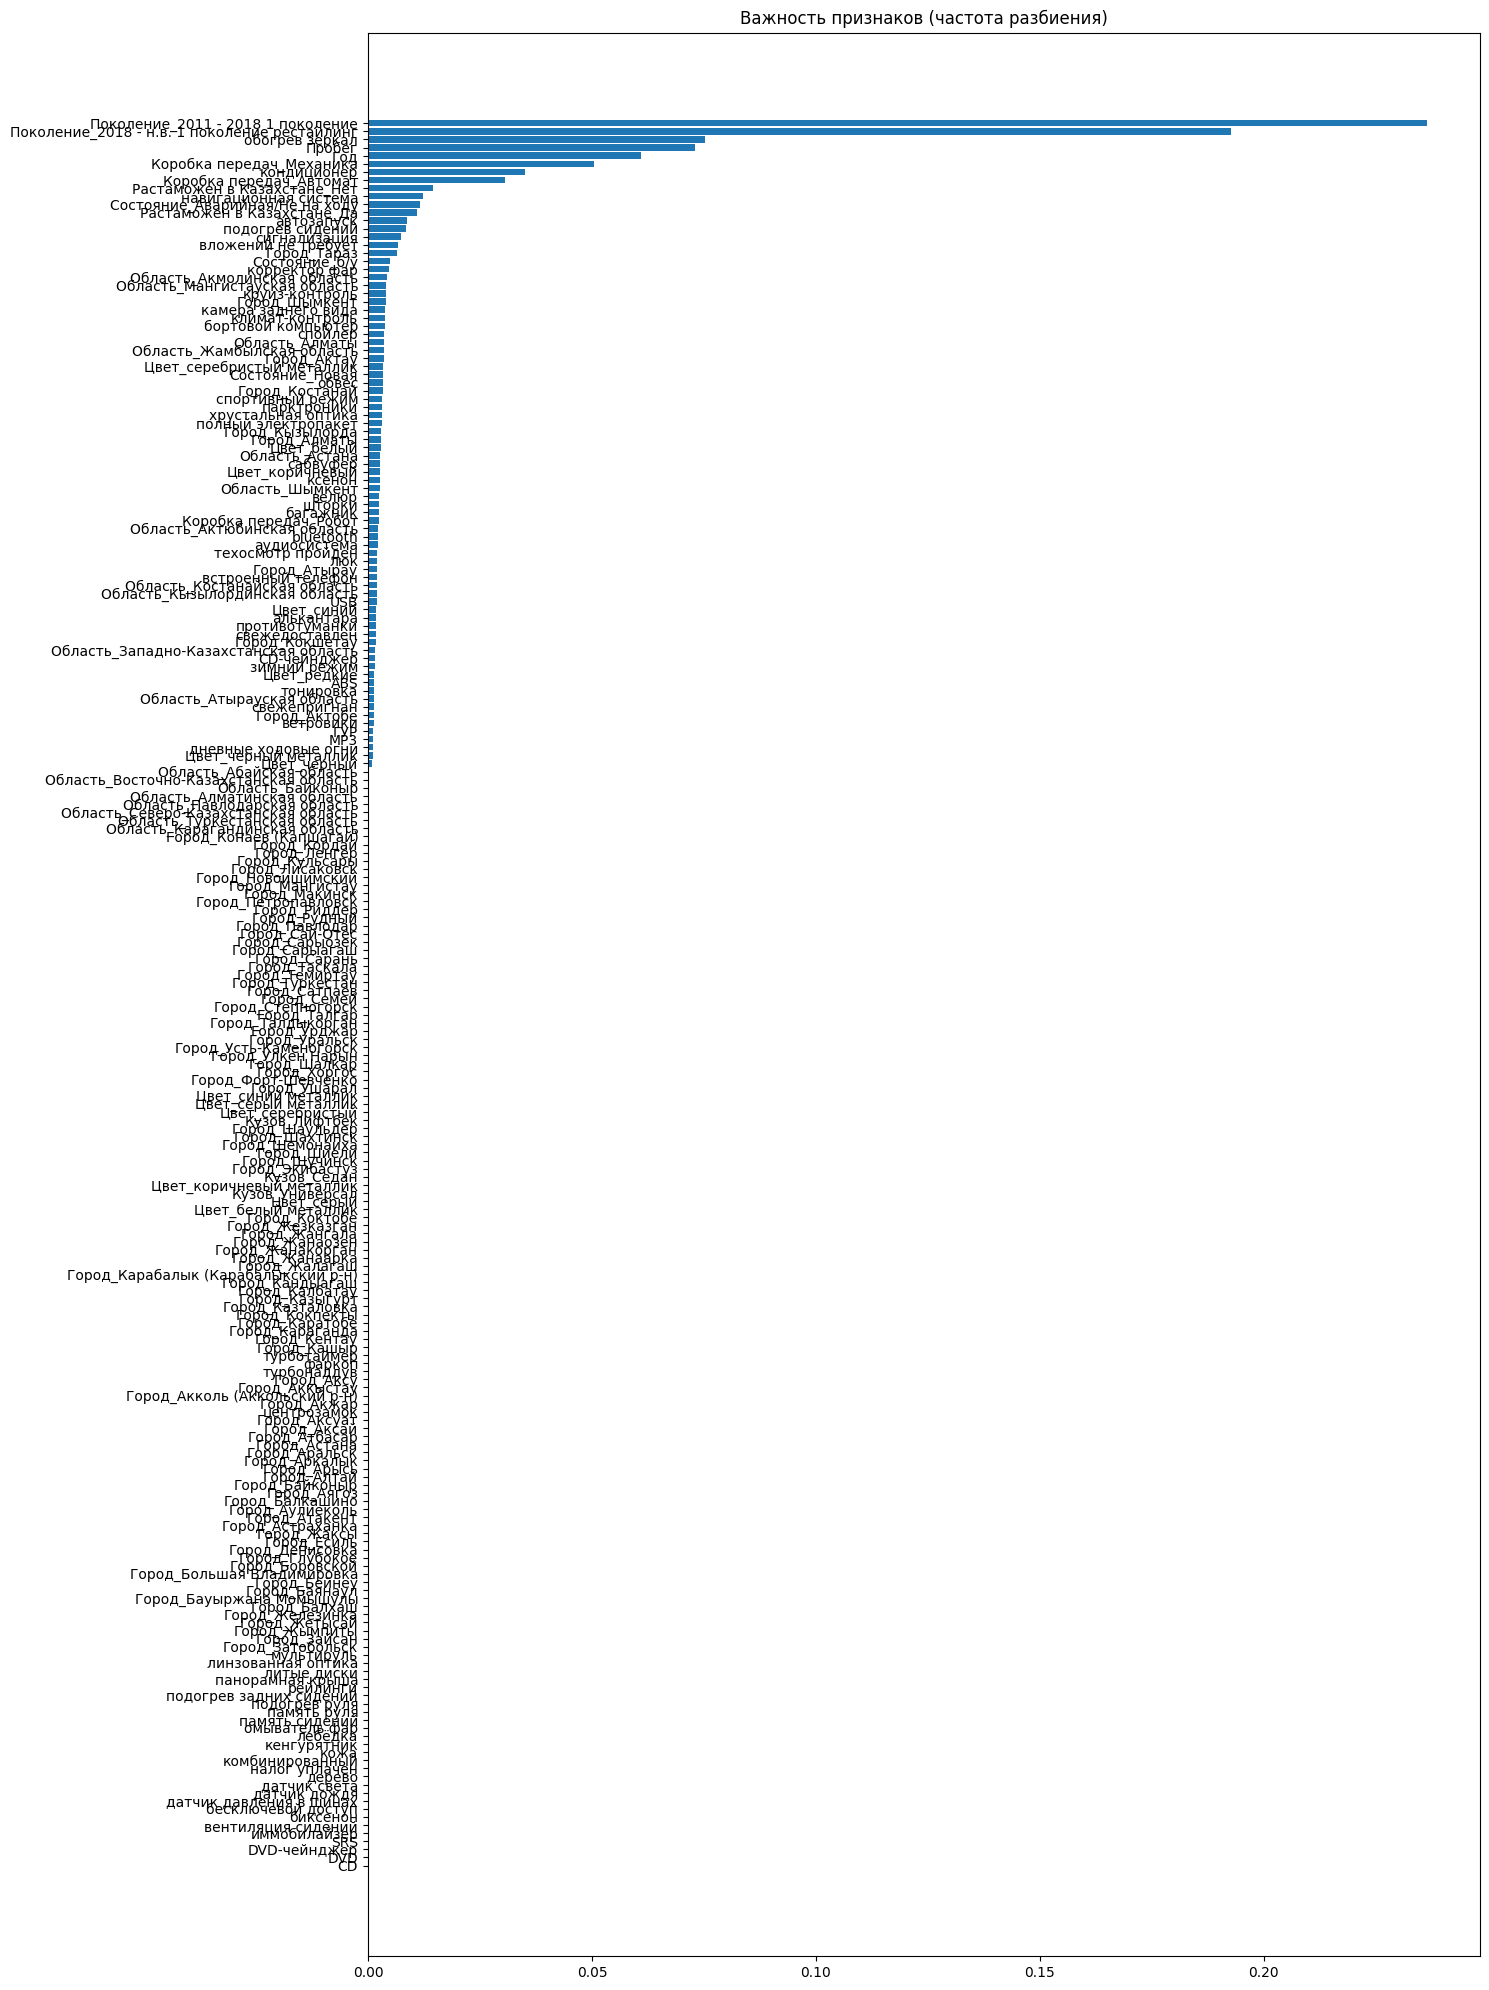

In [13]:
fig = plt.figure(figsize=(15, 20))
plt.barh(features_importances_df['features'], features_importances_df['importance'])
plt.title('Важность признаков (частота разбиения)')
plt.tight_layout()
plt.show()

In [15]:
#  Удаляем бесполезные признаки
weight_not_zero = features_importances_df[features_importances_df['importance'] > 0]
len(weight_not_zero)

80

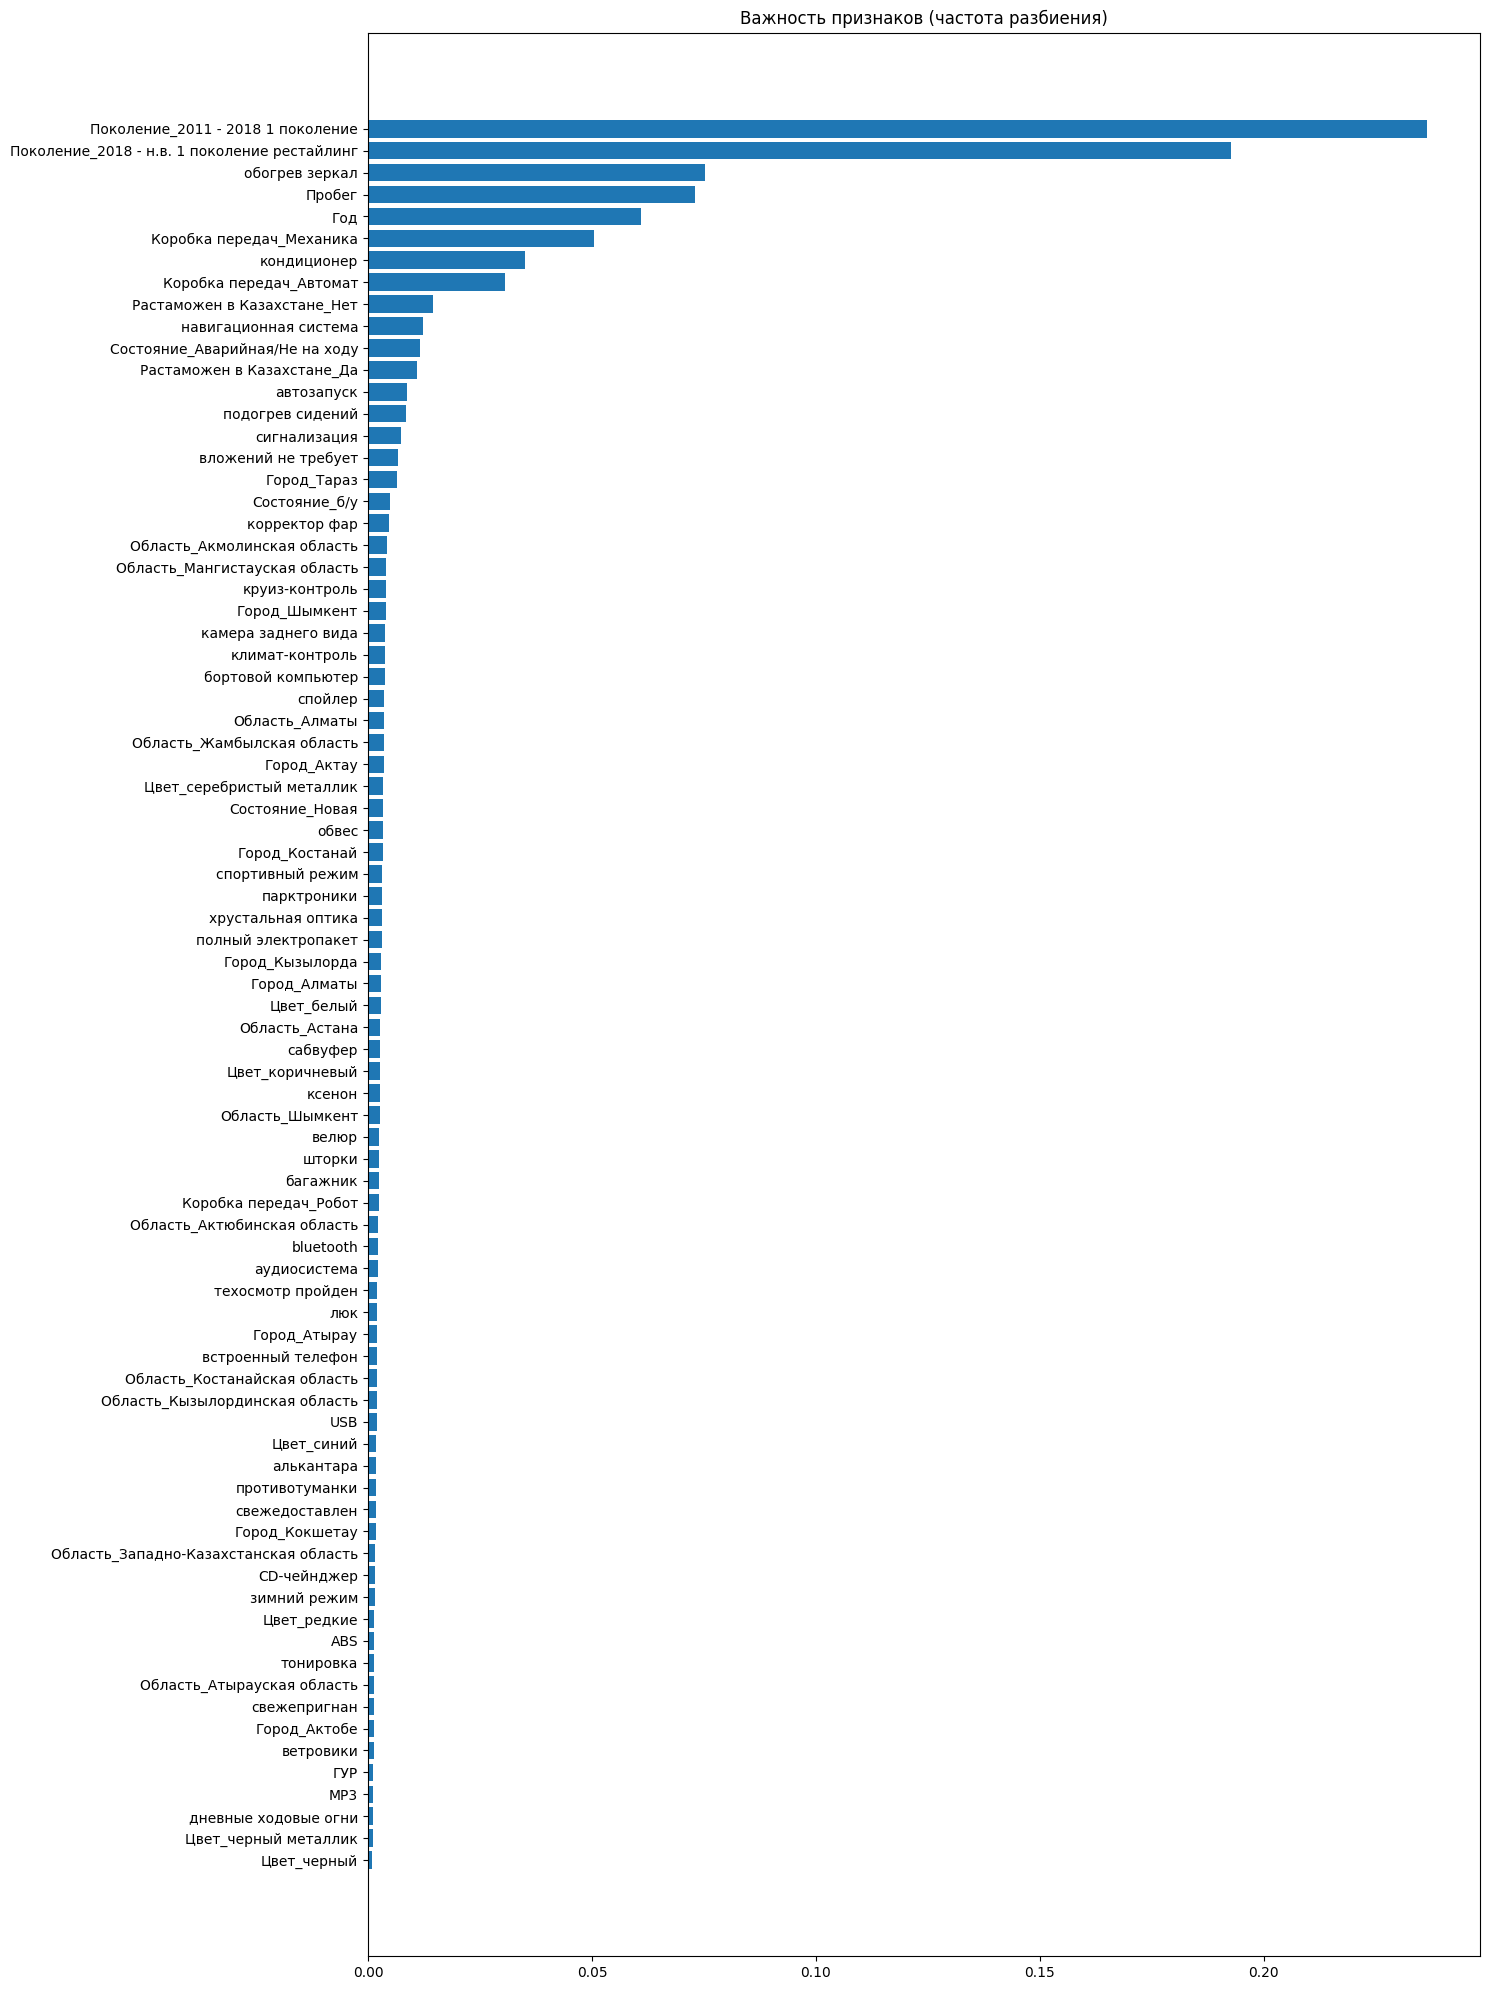

In [16]:
fig = plt.figure(figsize=(15, 20))
plt.barh(weight_not_zero['features'], weight_not_zero['importance'])
plt.title('Важность признаков (частота разбиения)')
plt.tight_layout()
plt.show()

In [17]:
#  Подбираем границу для отсечения лишних признаков из оставшихся
best_params_list = []
scores_list = []

for i, weight in tqdm(enumerate(weight_not_zero['importance']), desc='Подбор границы', unit='trial', total=len(weight_not_zero)):
    weight_useles = features_importances_df[features_importances_df['importance'] < weight]['features']

    x_train_imp = X_train.drop(weight_useles, axis=1)
    x_test_imp = X_test.drop(weight_useles, axis=1)
    print(f" ==== Испытание {i + 1} ==== ")
    print(f'Количество признаков: {x_test_imp.shape[1]}')

    best_params = {}
    _, rmse_test_imp, _, best_params_imp = tune_model(
        x_train_imp, 
        y_train, 
        x_test_imp, 
        y_test, 
        param_stages, 
        n_trials=30,
        out_print=False,
        stages=[1, 2, 3]
        )
    print(f'RMSE: {rmse_test_imp}')
    best_params_list.append(best_params_imp)
    scores_list.append(rmse_test_imp)

best_score_imp = min(scores_list)
print(f'Лучшая метрика: {best_score_imp}')

Подбор границы:   0%|          | 0/80 [00:00<?, ?trial/s]

 ==== Испытание 1 ==== 
Количество признаков: 80


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 418365.5625
 ==== Испытание 2 ==== 
Количество признаков: 79


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 415495.28125
 ==== Испытание 3 ==== 
Количество признаков: 78


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 406553.5
 ==== Испытание 4 ==== 
Количество признаков: 77


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 424650.15625
 ==== Испытание 5 ==== 
Количество признаков: 76


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 415342.0
 ==== Испытание 6 ==== 
Количество признаков: 75


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 414931.46875
 ==== Испытание 7 ==== 
Количество признаков: 74


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 408838.21875
 ==== Испытание 8 ==== 
Количество признаков: 73


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 406820.15625
 ==== Испытание 9 ==== 
Количество признаков: 72


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 408963.25
 ==== Испытание 10 ==== 
Количество признаков: 71


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 421582.3125
 ==== Испытание 11 ==== 
Количество признаков: 70


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 401647.28125
 ==== Испытание 12 ==== 
Количество признаков: 69


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 410143.59375
 ==== Испытание 13 ==== 
Количество признаков: 68


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 417370.34375
 ==== Испытание 14 ==== 
Количество признаков: 67


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 413673.3125
 ==== Испытание 15 ==== 
Количество признаков: 66


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 408938.875
 ==== Испытание 16 ==== 
Количество признаков: 65


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 414078.5
 ==== Испытание 17 ==== 
Количество признаков: 64


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 413877.5
 ==== Испытание 18 ==== 
Количество признаков: 63


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 418397.875
 ==== Испытание 19 ==== 
Количество признаков: 62


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 412820.34375
 ==== Испытание 20 ==== 
Количество признаков: 61


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 418540.8125
 ==== Испытание 21 ==== 
Количество признаков: 60


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 415793.28125
 ==== Испытание 22 ==== 
Количество признаков: 59


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 406063.03125
 ==== Испытание 23 ==== 
Количество признаков: 58


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 409663.96875
 ==== Испытание 24 ==== 
Количество признаков: 57


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 406031.1875
 ==== Испытание 25 ==== 
Количество признаков: 56


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 404701.375
 ==== Испытание 26 ==== 
Количество признаков: 55


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 414507.6875
 ==== Испытание 27 ==== 
Количество признаков: 54


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 411009.625
 ==== Испытание 28 ==== 
Количество признаков: 53


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 416561.40625
 ==== Испытание 29 ==== 
Количество признаков: 52


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 410257.0625
 ==== Испытание 30 ==== 
Количество признаков: 51


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 415912.25
 ==== Испытание 31 ==== 
Количество признаков: 50


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 410202.28125
 ==== Испытание 32 ==== 
Количество признаков: 49


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 419000.1875
 ==== Испытание 33 ==== 
Количество признаков: 48


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 406884.78125
 ==== Испытание 34 ==== 
Количество признаков: 47


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 414174.84375
 ==== Испытание 35 ==== 
Количество признаков: 46


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 415753.6875
 ==== Испытание 36 ==== 
Количество признаков: 45


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 418182.90625
 ==== Испытание 37 ==== 
Количество признаков: 44


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 415193.65625
 ==== Испытание 38 ==== 
Количество признаков: 43


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 410026.53125
 ==== Испытание 39 ==== 
Количество признаков: 42


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 410681.21875
 ==== Испытание 40 ==== 
Количество признаков: 41


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 420618.6875
 ==== Испытание 41 ==== 
Количество признаков: 40


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 418385.75
 ==== Испытание 42 ==== 
Количество признаков: 39


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 412086.9375
 ==== Испытание 43 ==== 
Количество признаков: 38


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 420202.0
 ==== Испытание 44 ==== 
Количество признаков: 37


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 409432.4375
 ==== Испытание 45 ==== 
Количество признаков: 36


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 416947.3125
 ==== Испытание 46 ==== 
Количество признаков: 35


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 423995.90625
 ==== Испытание 47 ==== 
Количество признаков: 34


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 417970.65625
 ==== Испытание 48 ==== 
Количество признаков: 33


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 422744.84375
 ==== Испытание 49 ==== 
Количество признаков: 32


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 426402.96875
 ==== Испытание 50 ==== 
Количество признаков: 31


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 423230.03125
 ==== Испытание 51 ==== 
Количество признаков: 30


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 418032.84375
 ==== Испытание 52 ==== 
Количество признаков: 29


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 422812.71875
 ==== Испытание 53 ==== 
Количество признаков: 28


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 424047.03125
 ==== Испытание 54 ==== 
Количество признаков: 27


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 426553.09375
 ==== Испытание 55 ==== 
Количество признаков: 26


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 417383.90625
 ==== Испытание 56 ==== 
Количество признаков: 25


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 415617.15625
 ==== Испытание 57 ==== 
Количество признаков: 24


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 418672.125
 ==== Испытание 58 ==== 
Количество признаков: 23


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 410503.6875
 ==== Испытание 59 ==== 
Количество признаков: 22


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 425181.25
 ==== Испытание 60 ==== 
Количество признаков: 21


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 429663.0
 ==== Испытание 61 ==== 
Количество признаков: 20


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 425526.1875
 ==== Испытание 62 ==== 
Количество признаков: 19


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 425751.21875
 ==== Испытание 63 ==== 
Количество признаков: 18


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 425714.0625
 ==== Испытание 64 ==== 
Количество признаков: 17


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 425506.1875
 ==== Испытание 65 ==== 
Количество признаков: 16


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 427427.15625
 ==== Испытание 66 ==== 
Количество признаков: 15


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 426774.34375
 ==== Испытание 67 ==== 
Количество признаков: 14


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 419202.96875
 ==== Испытание 68 ==== 
Количество признаков: 13


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 422785.5625
 ==== Испытание 69 ==== 
Количество признаков: 12


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 429331.90625
 ==== Испытание 70 ==== 
Количество признаков: 11


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 433426.4375
 ==== Испытание 71 ==== 
Количество признаков: 10


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 471416.65625
 ==== Испытание 72 ==== 
Количество признаков: 9


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 473157.9375
 ==== Испытание 73 ==== 
Количество признаков: 8


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 474359.21875
 ==== Испытание 74 ==== 
Количество признаков: 7


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 475421.53125
 ==== Испытание 75 ==== 
Количество признаков: 6


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 486395.09375
 ==== Испытание 76 ==== 
Количество признаков: 5


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 515628.0625
 ==== Испытание 77 ==== 
Количество признаков: 4


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 555870.25
 ==== Испытание 78 ==== 
Количество признаков: 3


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 663256.1875
 ==== Испытание 79 ==== 
Количество признаков: 2


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 678847.4375
 ==== Испытание 80 ==== 
Количество признаков: 1


  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

  0%|          | 0/30 [00:00<?, ?trial/s]

RMSE: 678958.625
Лучшая метрика: 401647.28125


In [18]:
#  Сохраняем параметры лучшей модели
select_imp_results = pd.DataFrame({
    'weight': weight_not_zero['importance'],
    'rmse': scores_list,
    'params_model': best_params_list
})
select_imp_results = select_imp_results.sort_values(by='rmse', ascending=True, ignore_index=True)
top_params = select_imp_results.iloc[0]
select_imp_results

,weight,rmse,params_model
0,0.001415,401647.28125,"{'n_estimators': 498, 'learning_rate': 0.05147..."
1,0.002061,404701.37500,"{'n_estimators': 488, 'learning_rate': 0.07195..."
2,0.002057,406031.18750,"{'n_estimators': 396, 'learning_rate': 0.09855..."
3,0.001974,406063.03125,"{'n_estimators': 429, 'learning_rate': 0.04764..."
4,0.001089,406553.50000,"{'n_estimators': 415, 'learning_rate': 0.02457..."
...,...,...,...
75,0.060849,515628.06250,"{'n_estimators': 129, 'learning_rate': 0.04571..."
76,0.072986,555870.25000,"{'n_estimators': 497, 'learning_rate': 0.01000..."
77,0.075181,663256.18750,"{'n_estimators': 142, 'learning_rate': 0.04120..."
78,0.192567,678847.43750,"{'n_estimators': 332, 'learning_rate': 0.03532..."


In [19]:
# Датасет с итоговыми признаками
weight_useles = features_importances_df[features_importances_df['importance'] < top_params['weight']]['features']
x_train_imp = X_train.drop(weight_useles, axis=1)
x_test_imp = X_test.drop(weight_useles, axis=1)

In [26]:
x_train_imp.shape

(1487, 70)

In [21]:
# Итоговая модель
model_end = XGBRegressor(**top_params['params_model'], random_state=42)
model_end.fit(x_train_imp, y_train)
y_pred_test = model_end.predict(x_test_imp)
y_pred_train = model_end.predict(x_train_imp)

rmse_test = root_mean_squared_error(y_test, y_pred_test)
rmse_train = root_mean_squared_error(y_train, y_pred_train)

print(f'RMSE test: {rmse_test}')
print(f'RMSE train: {rmse_train}')

RMSE test: 401647.28125
RMSE train: 352404.28125


In [22]:
import json

In [23]:
with open('best_params_model.json', 'w') as f:
    json.dump(top_params['params_model'], f, indent=4)

In [24]:
x_test_imp.iloc[:5, :].to_csv('primer_x.csv', sep=',', index=False)

In [25]:
model_end.save_model('xgboost_model2.json')